<a href="https://colab.research.google.com/github/greyhound101/multilingial/blob/master/spanish_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [2]:
pip install sentencepiece 

In [3]:
pip install transformers

In [4]:
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0   101k      0 --:--:-- --:--:-- --:--:--  101k
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Uninstalling torch-1.8.0a0+unknown:
  Successfully uninstalled torch-1.8.0a0+unknown
Done updating TPU runtime
Uninstalling torchvision-0.9.0a0+e617474:
  Successfully uninstalled torchvision-0.9.0a0+e617474
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...
- [1 files][122.8 MiB/122.8 MiB]                                                
Operation completed over 1 objects/122.8 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp36-cp36m-linux_x86_64.whl...
| [1 files][131.1 MiB/131.1 MiB]                                                
Operation completed over 1 objects/131.1 MiB.                    

In [5]:
import gc
import os
import time
import math
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from transformers import *
from sklearn.metrics import *
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from torch import Tensor
from torch.optim import *
from torch.nn.modules.loss import *
from torch.optim.lr_scheduler import * 
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler
import pandas as pd



def regular_encode(texts, tokenizer, maxlen=192):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

class Transformer(nn.Module):
    def __init__(self, transformer, num_classes=1):
        """
        Constructor
        
        Arguments:
            model {string} -- Transformer to build the model on. Expects "camembert-base".
            num_classes {int} -- Number of classes (default: {1})
        """
        super().__init__()
        
        self.transformer = transformer

        self.nb_features = self.transformer.pooler.dense.out_features
        # for param in self.transformer.parameters():
        #   param.requires_grad = False
        self.pooler = nn.Sequential(
            nn.Linear(self.nb_features, num_classes), 
            nn.Sigmoid(),
        )


    def forward(self, tokens):
        """
        Usual torch forward function
        
        Arguments:
            tokens {torch tensor} -- Sentence tokens
        
        Returns:
            torch tensor -- Class logits
        """
        hidden_states = self.transformer(
            tokens, attention_mask=(tokens > 0).long()
        )[1]

        # hidden_states = hidden_states[-1][:, 0] # Use the representation of the first token of the last layer

        ft = self.pooler(hidden_states)

        return ft


In [6]:
class bce(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(bce, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        one=(1-targets)*torch.log(1-inputs)
        zero=(targets*torch.log(inputs))
        loss = torch.mean((one+zero)*-1)
        
        return loss
class JigsawDataset:
    """
    Torch dataset for training and validating
    """
    def __init__(self, x,y,is_test):
        super().__init__()
        self.y = y 
        self.is_test=is_test
        self.sentences = x
        

    def __len__(self):
        return self.sentences.shape[0]

    def __getitem__(self, idx):
      len=self.__len__()
      if idx>len:
        idx=idx%len
      if self.is_test==0:
        return torch.tensor(self.sentences[idx]), torch.tensor(self.y[idx]).float()
      else:
        return torch.tensor(self.sentences[idx])


In [7]:
from sklearn.model_selection import train_test_split
from statistics import mean
import torch_xla
from sklearn.preprocessing import *
import torch_xla.debug.metrics as met
import torch_xla.distributed.data_parallel as dp
import torch_xla.distributed.parallel_loader as pl
import torch_xla.utils.utils as xu
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.test.test_utils as test_utils
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
import gc
import os
import cv2
import zipfile
from pathlib import Path
import random
import argparse
import sys
from statistics import mean
import yaml
from tqdm.notebook import tqdm
import time
import albumentations as A
from sklearn.model_selection import StratifiedKFold
import random
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from typing import Dict
from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50, resnet18, resnet34, resnet101
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

def train_all(train_loader, model, device, optimizer):
    model.train()
    # t = tqdm(train_loader, disable=not xm.is_master_ordinal())
    model.train()
    lss=bce()
    loss1=[]
    for step, (x, y_batch) in enumerate(train_loader): 
            
            # x = x.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x)
            
            loss = lss(y_pred.view(-1).float(), y_batch.float())
            loss.backward()
            loss1.append(loss.item())
            xm.optimizer_step(optimizer)
            
            model.zero_grad()
    return mean(loss1)

def valid_all(train_loader, model, device):
    # t = tqdm(train_loader, disable=not xm.is_master_ordinal())
    lss=bce()
    loss1=[]
    for step, (x, y_batch) in enumerate(train_loader): 
            
            # x = x.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x)
            
            loss = lss(y_pred.view(-1).float(), y_batch.float())
            loss1.append(loss.item())
            
    return mean(loss1)

def predict_all(train_loader, model,device):
    # t = tqdm(train_loader, disable=not xm.is_master_ordinal())
    predict=[]
    for step, (x) in tqdm(enumerate(train_loader)): 
            
            y_pred = model(x.to(device))
            predict.append(y_pred)
            
    return predict


def load_data(lang):
    with zipfile.ZipFile('/content/gdrive/My Drive/multilingual/jigsaw-toxic-comment-train-google-'+lang+'-cleaned.csv.zip', 'r') as zip_ref:
      zip_ref.extractall('')
    trn=pd.read_csv('/content/jigsaw-toxic-comment-train-google-'+lang+'-cleaned.csv',usecols=['toxic','comment_text'])
    trn['lang']=lang
    tst=pd.read_csv('/content/gdrive/My Drive/multilingual/test.csv.zip',usecols=['lang','content'])  
    sub=pd.read_csv('/content/gdrive/My Drive/multilingual/submission.csv')
    val=pd.read_csv( '/content/gdrive/My Drive/multilingual/validation.csv.zip',usecols=['lang','comment_text','toxic'])  
    tst.columns=['comment_text','lang']
    tst['toxic']=sub['toxic']
    df=pd.concat([trn,tst,val],0)
    return df.loc[df['lang']==lang].reset_index(drop=True).drop(['lang'],1)


def get_lang(val,tst,lang):
  df=pd.concat([val,tst],0)
  return df.loc[df['lang']==lang].reset_index(drop=True).drop(['id','lang'],1)

def main():
    epochs=1
    batch_size=16
    learning_rate=1e-5
    seed=42

    # Setting seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    df=load_data('es')
    tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
    x_train = regular_encode(list(df.comment_text.values), tokenizer, maxlen=192)
    y_train = df.toxic.values
    X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

    idx=df.loc[(df['toxic']>0) & (df['toxic']<1)].index
    test=x_train[idx]




    def run():

        torch.manual_seed(seed)

        device = xm.xla_device()
        model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
        model=Transformer(model).to(device)


        #Training
        train_dataset = JigsawDataset(X_train,Y_train,0)


        train_sampler = torch.utils.data.distributed.DistributedSampler(
            train_dataset,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=False
        )
        train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
            sampler=train_sampler,
            drop_last=False,
            num_workers=2
        )

        

        #Validation
        validation_dataset = JigsawDataset(X_test,Y_test,0)


        validation_sampler = torch.utils.data.distributed.DistributedSampler(
            validation_dataset,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=False
        )
        validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size,
            sampler=validation_sampler,
            drop_last=False,
            num_workers=2
        )




        #test
        test_dataset = JigsawDataset(test,None,1)


        test_sampler = torch.utils.data.distributed.DistributedSampler(
            test_dataset,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=False
        )
        test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,
            sampler=test_sampler,
            drop_last=False,
            num_workers=2
        )


        optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate * xm.xrt_world_size(),weight_decay=1e-3)


        xm.master_print("Training is Starting ...... ")
        total_loss=[]
        valid_loss=[]
        predictions=[]
        for i in tqdm(range(3)):
          para_loader = pl.ParallelLoader(train_loader, [device])
          total_loss.append(train_all(para_loader.per_device_loader(device),model,device,optimizer))

        
        for i in tqdm(range(3)):
          para_loader = pl.ParallelLoader(validation_loader, [device])
          valid_loss.append(valid_all(para_loader.per_device_loader(device),model,device))



        state = { 'state_dict': model.state_dict(),
             'optimizer': optimizer.state_dict()}
        xm.save(state, '/content/gdrive/My Drive/spanish')


        np.save('loss.npy',total_loss)
        np.save('valid.npy',valid_loss)
            


    def _mp_fn(rank, flags):
        torch.set_default_tensor_type('torch.FloatTensor')
        run()
        
    FLAGS={}
    xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')

In [8]:
main()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training is Starting ...... 


100%|██████████| 3/3 [23:59<00:00, 479.75s/it]



100%|██████████| 3/3 [05:13<00:00, 104.37s/it]


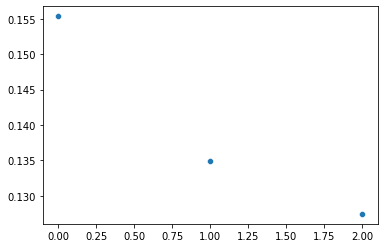

In [9]:
import seaborn as sns
a=np.load('loss.npy',allow_pickle=False)
sns.scatterplot(y=a,x=range(len(a)))

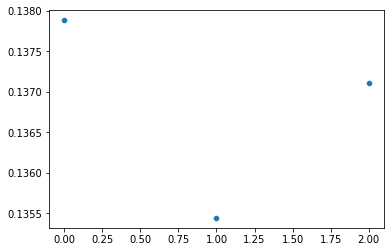

In [10]:

a=np.load('valid.npy',allow_pickle=False)
sns.scatterplot(y=a,x=range(len(a)))